# Проект "Прогнозирование температуры звезды"  

__Задача:__   
  
 Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.    
 
__Критерий оценки:__ RMSE <=4500  

__Характеристики:__  

__Абсолютная температура T(K)__ — температура на поверхности звезды в Кельвинах.  Целевой признак.
__Относительная светимость L/Lo__ — светимость звезды относительно Солнца.  
__Относительный радиус R/Ro__ — радиус звезды относительно радиуса Солнца.  
__Абсолютная звёздная величина Mv__ — физическая величина, характеризующая блеск звезды.  
__Звёздный цвет (white, red, blue, yellow, yellow-orange и др.)__ — цвет звезды, который определяют на основе спектрального анализа.  
__Тип звезды__  

|Тип звезды|	Номер, соответствующий типу|  
|----------|-------------------------------|  
|Коричневый карлик|	0|  
|Красный карлик	|1|  
|Белый карлик	|2|  
|Звёзды главной последовательности|	3|  
|Сверхгигант	|4|    
|Гипергигант	|5|    
  
  

  
__План проекта:__

1. Знакомство с датасетом
2. Предобработка данных
3. Визуализация данных
    - числовые признакми
    - категориальные признаки
    - корреляция
    - попарное сравнение
4. Подготовка к моделированию
5. Моделирование
    - Baseline
    - BatchNorm
    - DropOut
    - Обучение батчами
6. Вывод

# Импорты/настройки

In [1]:
!pip install phik -q
!pip install pandas==2.1.3 -q
!pip install numpy==1.26.2 -q
!pip install matplotlib==3.8.2 -q
!pip install seaborn==0.13.0 -q
!pip install scikit-learn==1.3.2 -q
!pip install torch==2.1.2 -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

from phik.report import plot_correlation_matrix

import warnings

sns.set_style('darkgrid')
sns.set_palette('colorblind')
warnings.filterwarnings('ignore')

RS = 888
LR = 1e-2
num_epochs = 2500


torch.use_deterministic_algorithms(True)
torch.manual_seed(RS)
np.random.seed(RS)
random.seed(RS)

def get_info():
    '''
     Возвращает основную информацию о датасете
     '''
    print(f'Размер датасета\nобъектов: {data.shape[0]}\nпризнаков: {data.shape[1]}\n', end='\n\n')
    print(data.info(memory_usage='deep'))
    display(data.sample(5))
    print(f'Полных дубликатов в датасете: {data.duplicated().sum()}', end='\n\n')
    print(f'Пропусков в датасете:\n{data.isna().sum()/data.shape[0] * 100}', end='\n\n')
    print(f'Уникальные значения поля  Star color:\n{data["Star color"].unique()}')
    display(data.describe().T)


def training(net, num_epochs):
    '''
        Функция обучения сети
    '''
    # Создание списка ошибок
    loss_values_train = []
    loss_values_test = []

    # Создание списка и словаря тестовых результатов и ошибок
    results = []
    losses = {}

    counter = 0

    # Оптимайзер
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)

    for epoch in range(num_epochs):

        # Обнуление градиента
        optimizer.zero_grad()

        # Предсказания
        preds = net.forward(x).flatten()

        # Вычисление ошибки
        loss_value = torch.sqrt(loss(preds, y))

        # Вычисление градиентов функции потерь
        loss_value.backward()

        # Добавление значения ошибки в список ошибок
        loss_value = loss_value.detach().numpy()
        loss_values_train.append(loss_value)

        # Шаг оптимизатора
        optimizer.step()

        # Режим предсказания
        net.eval()

        # Предсказание на тестовых данных
        with torch.no_grad():
            test_preds = net.forward(x_test).flatten()
            loss_result = loss(test_preds, y_test)

        # Добавление значения ошибки в список ошибок
        loss_result = loss_result.detach().numpy()
        loss_values_test.append(loss_result)

        # Добавление тестовых предсказаний и ошибки в список и словарь
        results.append(test_preds)
        losses[counter] = loss_result
        counter +=1

        # Возврат к тренировочному режиму
        net.train()
        
    return loss_values_train, loss_values_test, losses, results
          
          
def evaluation(losses, results, target_test):
    '''
    Функция вычисления метрики
    '''
    # Обратное масштабирование таргета
    target_test = pd.Series(target_test)
    target_test = target_test.values.reshape(-1,1)
    target_test = scaler.inverse_transform(target_test)
    target_test = target_test.reshape(60,)
    target_test = pd.Series(target_test)

    # Обратное масштабирование предсказаний
    best = min(losses, key=losses.get)
    preds = results[best].detach().numpy()
    preds = pd.Series(preds)
    preds = preds.values.reshape(-1,1)
    preds = scaler.inverse_transform(preds)
    preds = preds.reshape(60,)
    preds = pd.Series(preds)

    # Создание ДФ таргет-предсказание
    df = target_test.to_frame(name='target')
    df['preds'] = preds
    df = df.sort_index()

    # Вычисление целевой метрики
    rmse = mean_squared_error(df['target'], df['preds'], squared=False)
    print(f'Проведено: {num_epochs} эпох.')
    print(f'Лучшая RMSE: {rmse} на {best+1} эпохе.')
    return df

          
def results_visualization(df):
    '''
    Функция визуализации результатов
    '''
    plt.figure(figsize=(16,10))
    sns.barplot(x=df.index, y=df['target'], label='факт')
    sns.barplot(x=df.index, y=df['preds'], width=0.3, label = 'предсказание')
    plt.title('Сопоставление предсказания и факта', fontsize='xx-large')
    plt.xlabel('Номер звезды', fontsize='xx-large')
    plt.ylabel('Температура звезды (К)', fontsize='xx-large');          
          
          
def RMSE_visualization(loss_values_train, loss_values_test):
    '''
    Функция визуализации поведения ошибки
    '''
    # Обратная трансформация ошибки на обучении
    loss_values_train = pd.Series(loss_values_train)
    loss_values_train = loss_values_train.values.reshape(-1,1)
    loss_values_train = scaler.inverse_transform(loss_values_train)
    loss_values_train = loss_values_train.reshape(num_epochs,)
    loss_values_train = pd.Series(loss_values_train)

    # Обратная трансформация ошибки на тесте
    loss_values_test = pd.Series(loss_values_test)
    loss_values_test = loss_values_test.values.reshape(-1,1)
    loss_values_test = scaler.inverse_transform(loss_values_test)
    loss_values_test = loss_values_test.reshape(num_epochs,)
    loss_values_test = pd.Series(loss_values_test)

    # Визуализация поведения ошибок
    plt.figure(figsize=(8,5))
    loss_values_test.plot(kind='line')
    loss_values_train.plot(kind='line', title='Визуализация RMSE')
    plt.legend(['обучение', 'тест']);

# Знакомство с датасетом

In [3]:
try:
    data = pd.read_csv('Datasets/6_class.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/6_class.csv')

In [4]:
get_info()

Размер датасета
объектов: 240
признаков: 7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 26.0 KB
None


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
166,166,19923,152000.000000,73.0000,-5.69,4,Blue
152,152,14060,1092.000000,5.7450,-2.04,3,Blue-white
128,128,2856,0.000896,0.0782,19.56,0,Red
57,57,3450,174000.000000,1284.0000,-11.28,5,Red
13,13,3628,0.005500,0.3930,10.48,1,Red


Полных дубликатов в датасете: 0

Пропусков в датасете:
Unnamed: 0                0.0
Temperature (K)           0.0
Luminosity(L/Lo)          0.0
Radius(R/Ro)              0.0
Absolute magnitude(Mv)    0.0
Star type                 0.0
Star color                0.0
dtype: float64

Уникальные значения поля  Star color:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


### Вывод  
|№|Факт|Заключение|
|-|----|-------------|
|1.| Датасет представлен 240 объектами, имеющими по 7 признаков.|Необходимо переименовать признаки для удобства|  
|2.| Вес датасета незначительный. Менее 1 мб.|Уменьшение памяти не требуется|  
|3.| Признак 'Unnamed: 0' - порядковый номер записи.|Не релевантен. Удалить.| 
|4.| Признаки 'Star type', 'Star color' - категориальные, остальные - числовые.|Перевести в соответствующие категории|
|5.| Пропуски не обнаружены.|Одной проблемой меньше|
|6.| Явные дубликаты отсутствуют.|Необходимо проверить на неявные.|
|7.| В уникальных значениях признака 'Star color' присутствуют смысловые дубликаты.|Провести обработку|  
|8.| Во всех релевантных числовых признаках имеются серьезные расхождения между средним и медианой.|Требуется визуализация|
|9.| Целевой признак - Temperature. Изменяется от 1939 до 40000 со стандартным отклонением 9552||



# Предобработка данных

In [5]:
# Сброс нерелевантного столбца
data.drop('Unnamed: 0', axis=1, inplace=True)

# Переименование признаков
data = data.rename(columns={'Temperature (K)':'temperature',
                            'Luminosity(L/Lo)':'luminosity',
                            'Radius(R/Ro)':'radius', 
                            'Absolute magnitude(Mv)':'magnitude',
                           'Star type':'star_type',
                           'Star color':'star_color'})

# Проверка на неявные дубликаты
print(f'Неявных дубликатов: {data.duplicated().sum()}')

Неявных дубликатов: 0


In [6]:
# Приведение значений признаков Star_color к единому формату
bw = sorted(data['star_color'].unique().tolist())[2:7]

data['star_color'] = data['star_color'].apply(lambda x: 'blue-white' if x in bw else x)
data['star_color'] = data['star_color'].apply(lambda x: 'blue' if x=='Blue ' else x)
data['star_color'] = data['star_color'].apply(lambda x: 'yellowish-white' if x=='Yellowish White' or x=='Yellowish White' else x)

data.loc[29,'star_color'] = 'pale-yellow-orange'
data['star_color'] = data['star_color'].str.lower()

In [7]:
# Проверка различий в признаках у схожих значений (ч.1)
data.loc[(data['star_color'] == 'white-yellow') | 
         (data['star_color'] == 'yellow-white') |
         (data['star_color'] == 'yellowish-white')]

,temperature,luminosity,radius,magnitude,star_type,star_color
25,12990,0.000085,0.00984,12.23,2,yellowish-white
27,7700,0.000110,0.01280,14.47,2,yellowish-white
28,11790,0.000150,0.01100,12.59,2,yellowish-white
34,5800,0.810000,0.90000,5.05,3,yellow-white
36,6757,1.430000,1.12000,2.41,3,yellow-white
37,6380,1.350000,0.98000,2.93,3,yellow-white
38,5936,1.357000,1.10600,4.46,3,yellow-white
39,5587,0.819000,0.99000,5.03,3,yellow-white
80,7100,0.000290,0.01200,14.09,2,white-yellow
90,5300,0.590000,0.91000,5.49,3,yellow-white


__Комментарий:__  
- Категории 'yellowish-white' и 'yellow-white' имеют различия в признаках, следовательно - это разные категории.
- Значение 'white-yellow' больше подходит под категорию 'yellowish-white'

In [8]:
# Проверка различий в признаках у схожих значений (ч.2)
data.loc[(data['star_color'] == 'white') | 
         (data['star_color'] == 'whitish')]

,temperature,luminosity,radius,magnitude,star_type,star_color
21,7740,0.00049,0.01234,14.02,2,white
22,7220,0.00017,0.01100,14.23,2,white
23,8500,0.00050,0.01000,14.50,2,white
33,9700,74.00000,2.89000,0.16,3,whitish
35,8052,8.70000,1.80000,2.42,3,whitish
81,10574,0.00014,0.00920,12.02,2,white
82,8930,0.00056,0.00950,13.78,2,white
88,13720,0.00018,0.00892,12.97,2,white
147,14732,0.00011,0.00892,12.89,2,white
148,7723,0.00014,0.00878,14.81,2,white


__Комментарий:__  
- Признаки 'white' и 'whitish' имеют различия в признаках, следовательно - это разные категории.

In [9]:
# Замена значения признака
data.loc[80,'star_color'] = 'yellowish-white'

# Перевод в категориальный тип данных
data[['star_type', 'star_color']] = data[['star_type', 'star_color']].astype('category')

# Проверка значений признака
sorted(data['star_color'].unique().tolist())

['blue',
 'blue-white',
 'orange',
 'orange-red',
 'pale-yellow-orange',
 'red',
 'white',
 'whitish',
 'yellow-white',
 'yellowish',
 'yellowish-white']

### Вывод
- Удален нерелевантный признак  
- Переименованы признаки  
- Проведена смена категории в признаках 'star_type', 'star_color'
- Проверка на неявные дубликаты таковых не выявила  
- Значения признака 'star_color' приведены к единому формату


# Визуализация распределений

### Числовые признаки

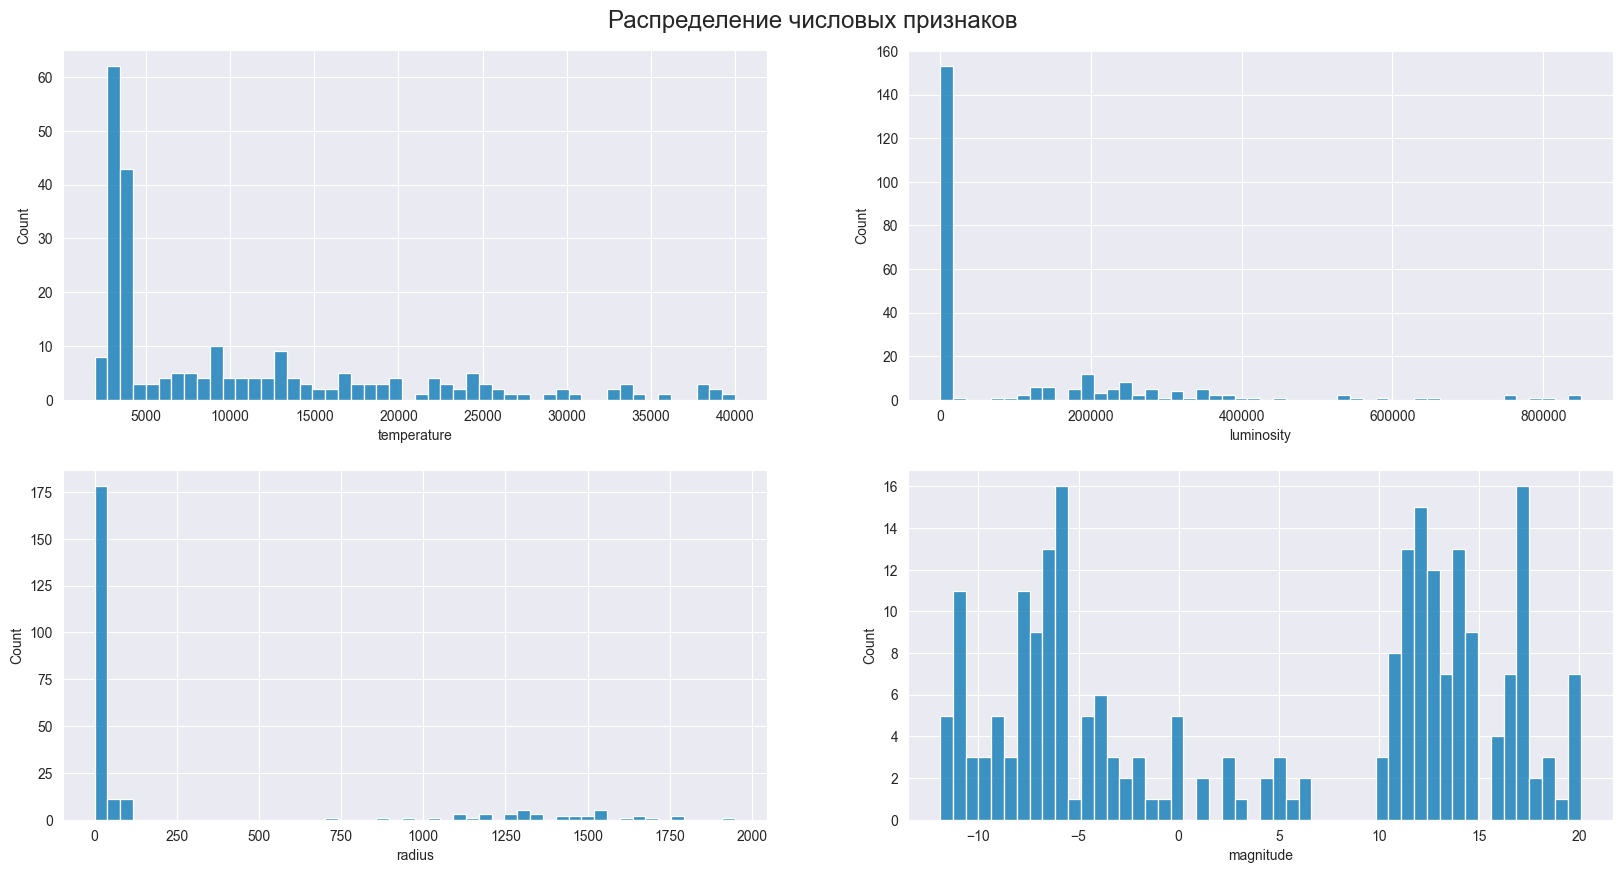

In [10]:
fig, axes = plt.subplots(2,2, figsize=(20,10))
sns.histplot(data['temperature'], bins=50,ax=axes[0,0])
sns.histplot(data['luminosity'], bins=50,ax=axes[0,1])
sns.histplot(data['radius'], bins=50,ax=axes[1,0])
sns.histplot(data['magnitude'], bins=50,ax=axes[1,1])
plt.suptitle('Распределение числовых признаков',fontsize='xx-large', y=0.92);

__Комментарий__  
- Подтверждается перекос значений признаков 'temperature', 'luminosity','radius' в левую сторону
- Распределение признака 'magnitude' бимодальное. Отдаленно может напоминать два колоколобразных распределения с присутствующими выбросами

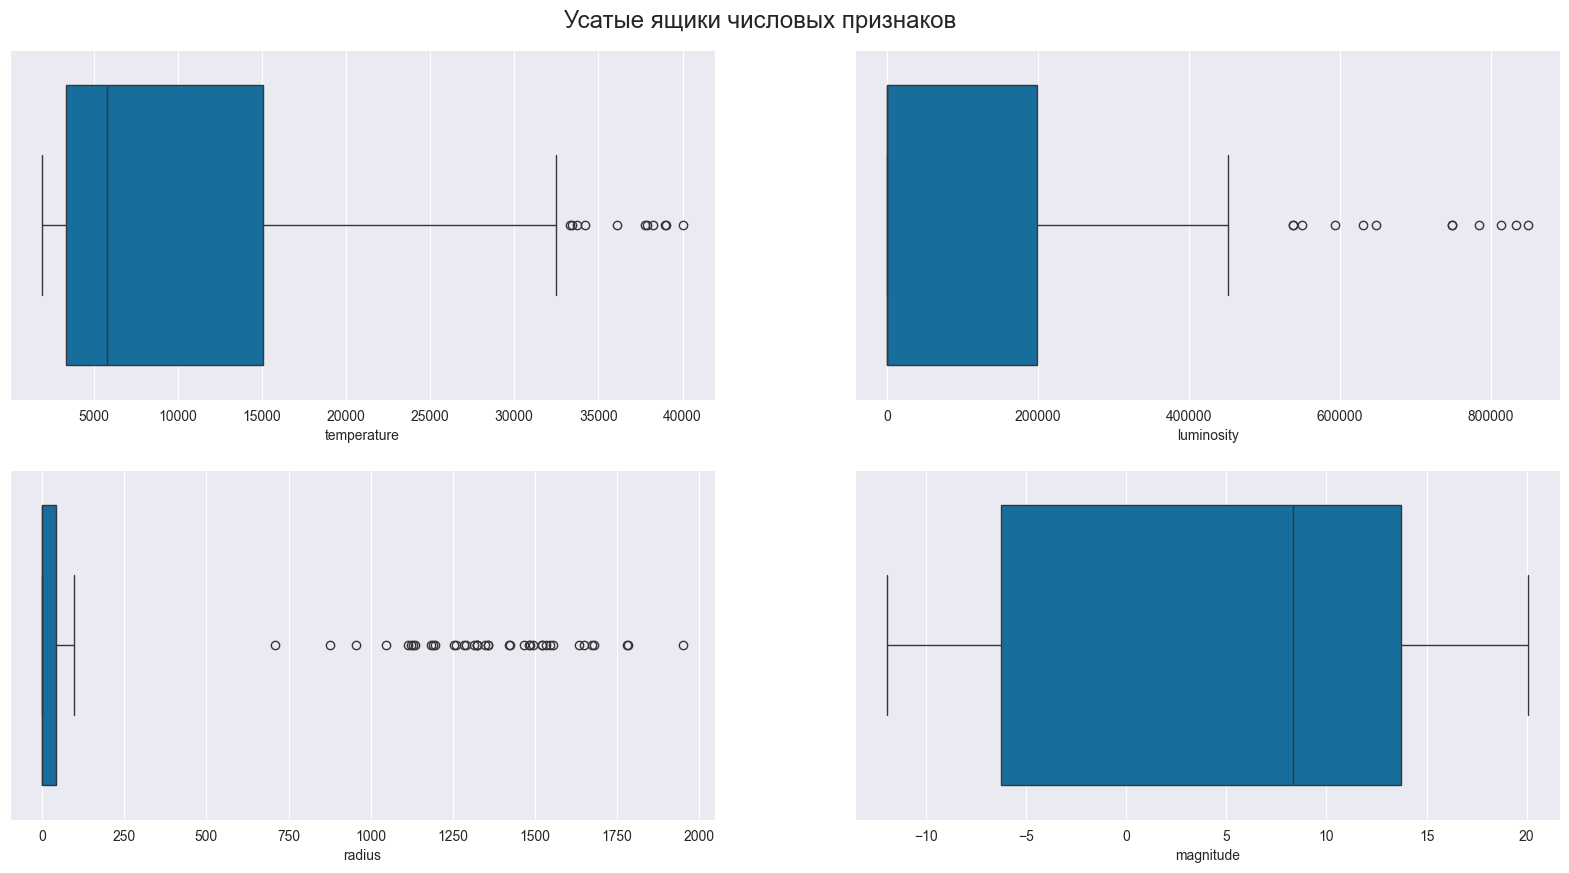

In [11]:
fig, axes = plt.subplots(2,2, figsize=(20,10))
sns.boxplot(x=data['temperature'], ax=axes[0,0])
sns.boxplot(x=data['luminosity'], ax=axes[0,1])
sns.boxplot(x=data['radius'], ax=axes[1,0])
sns.boxplot(x=data['magnitude'], ax=axes[1,1])
plt.suptitle('Усатые ящики числовых признаков',fontsize='xx-large', y=0.92);

__Комментарий__    
- Признак 'magnitude' выглядит наиболее равномерным.
- Признаки 'radius','luminosity' сильно зажаты влево.


### Категориальные признаки

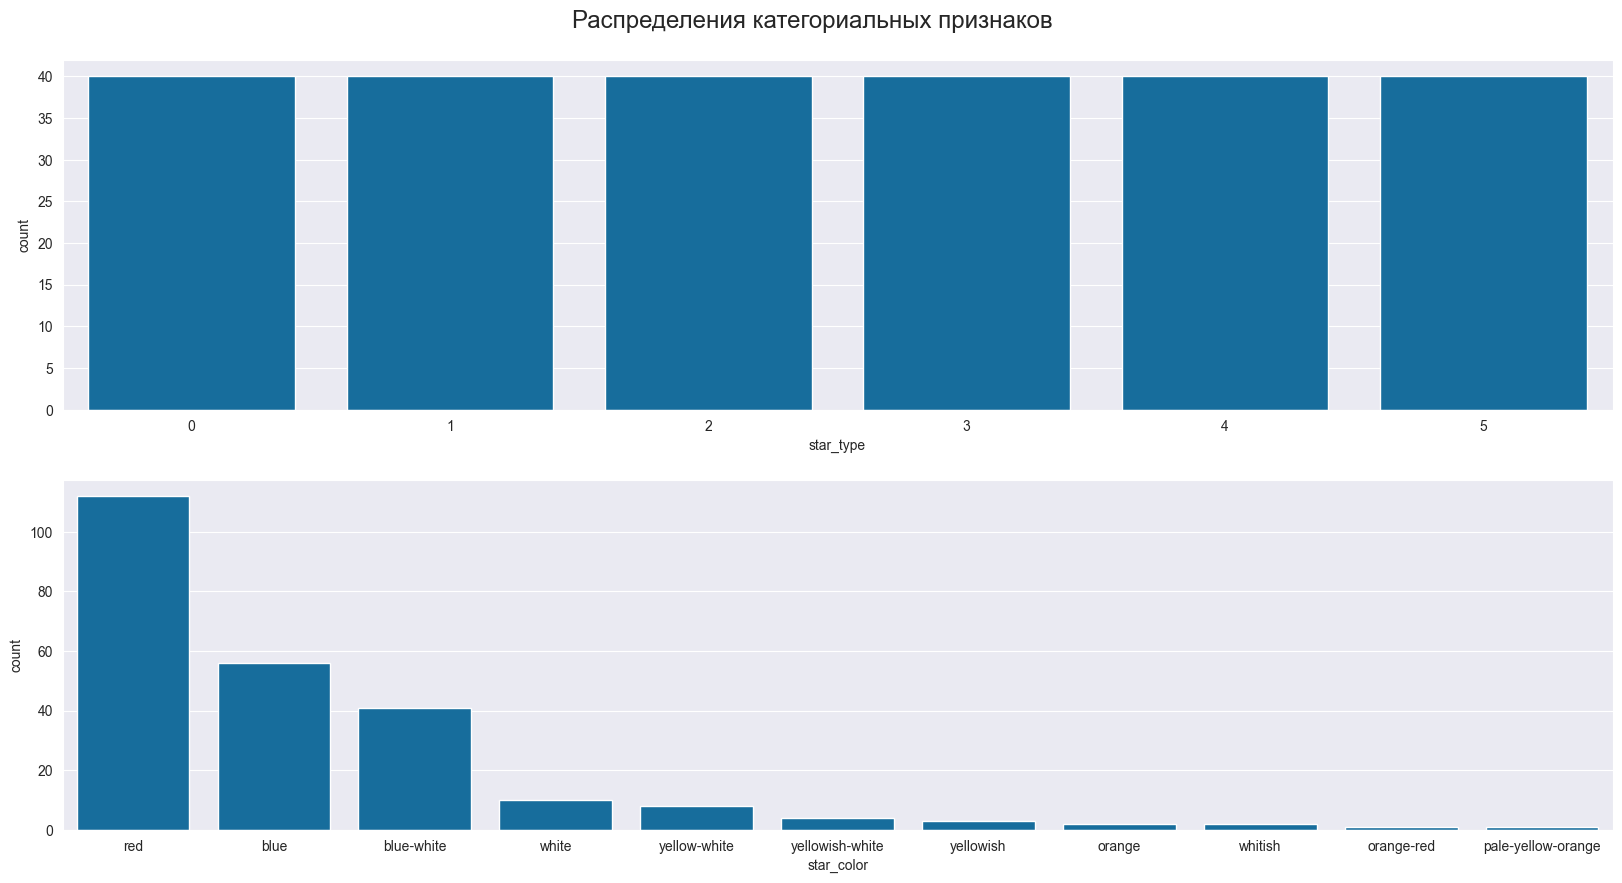

In [12]:
fig, axes = plt.subplots(2,1, figsize=(20,10))
sns.countplot(x=data['star_type'], ax=axes[0])
sns.countplot(x=data['star_color'], order=data['star_color'].value_counts().index,ax=axes[1])
plt.suptitle('Распределения категориальных признаков', y=0.93, fontsize='xx-large');

__Комментарий__    
- В датасете представлено 5 типов звезд, по 40 штук в каждой категории.
- Наиболее часто встречаются звезды красного цвета, наиболее редкие - бледно-желто-оранжевые

### Корреляция

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'magnitude']


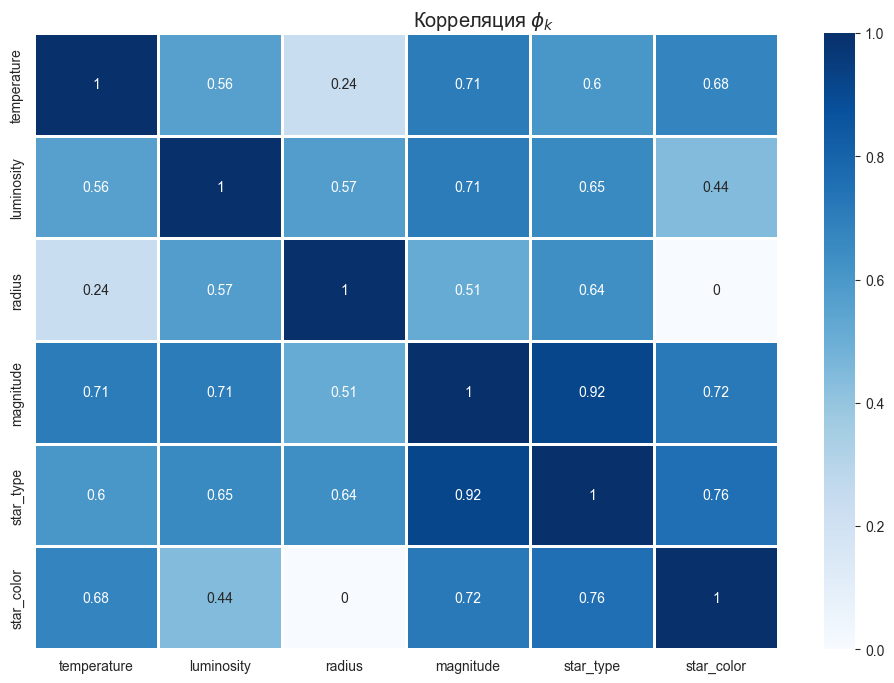

In [13]:
overview = data.phik_matrix()
plt.figure(figsize=(12,8))
sns.heatmap(overview, annot=True, linewidths=0.8, cmap='Blues', vmin=0, vmax=1)
plt.suptitle('Корреляция $\phi_k$', y=0.91, fontsize='x-large');

__Комментарий__  
- Сильная корреляция у признаков magnitude и star_type (0.92)
- Очень слабая между radius и temperature (0.24)
- Отсутствует между признаками radius и star_color 
- Высокая между остальными признаками (0.51 - 0.76)


### Попарное сравнение

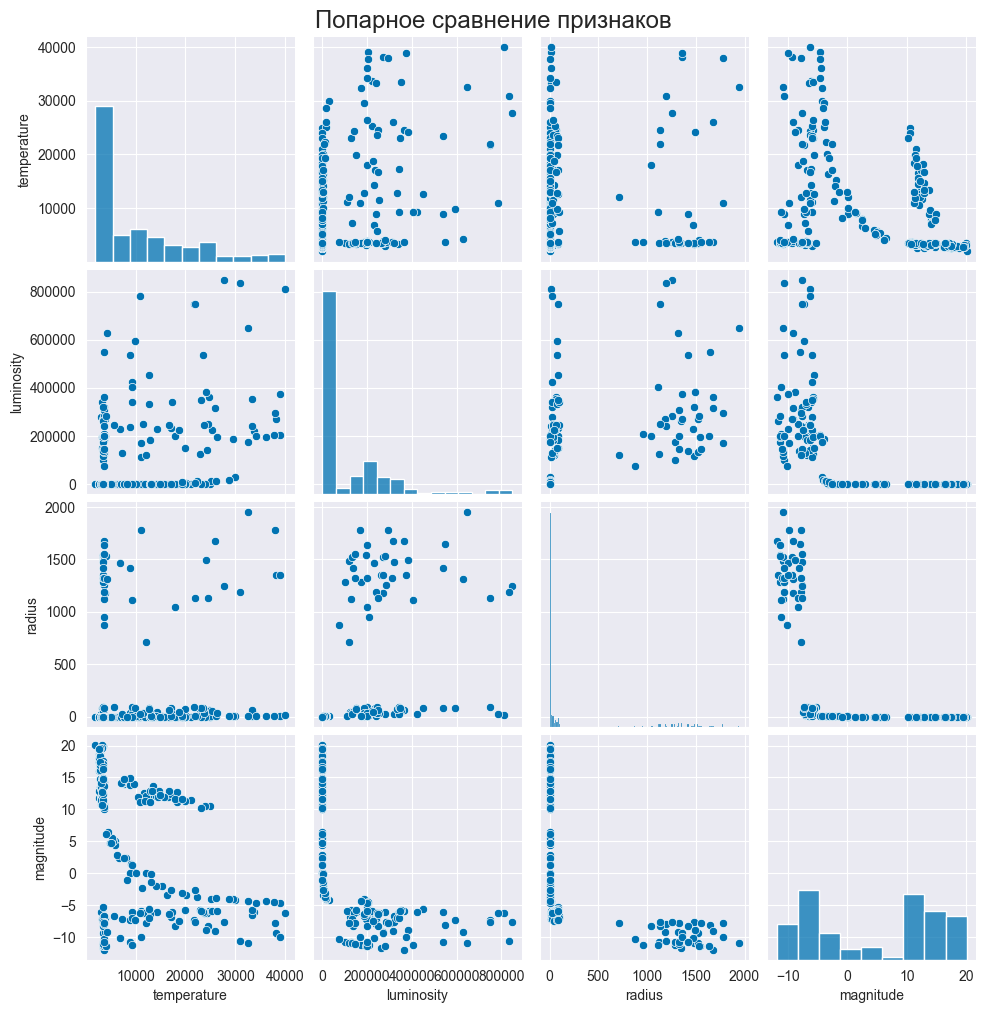

In [14]:
sns.pairplot(data)
plt.suptitle('Попарное сравнение признаков', y=1.01, fontsize='xx-large');

__Комментарий__    
- Попарное сравнение не очень информативно из-за зажатости признаков.
- Тем не менее заметны несколько кластеров звезд с различной связью. Например у целевой переменной temperature: 
     - при рассмотрении с признаками radius и luminosity имеется две перпендикулярные линии + набор точек разбросанных по графику.  
     - при рассмотрении с magnitude можно разбить на три кластера - гиперболическую кривую, область ниже нуля и небольшую группу по центру графика.
---
Необходима обработка зажатых признаков:  
- логарифмирование для luminosity и radius  
- масштабирование для temperature

In [15]:
# Логарифмирование
data['luminosity'] = np.log(data['luminosity'])
data['radius'] = np.log(data['radius'])

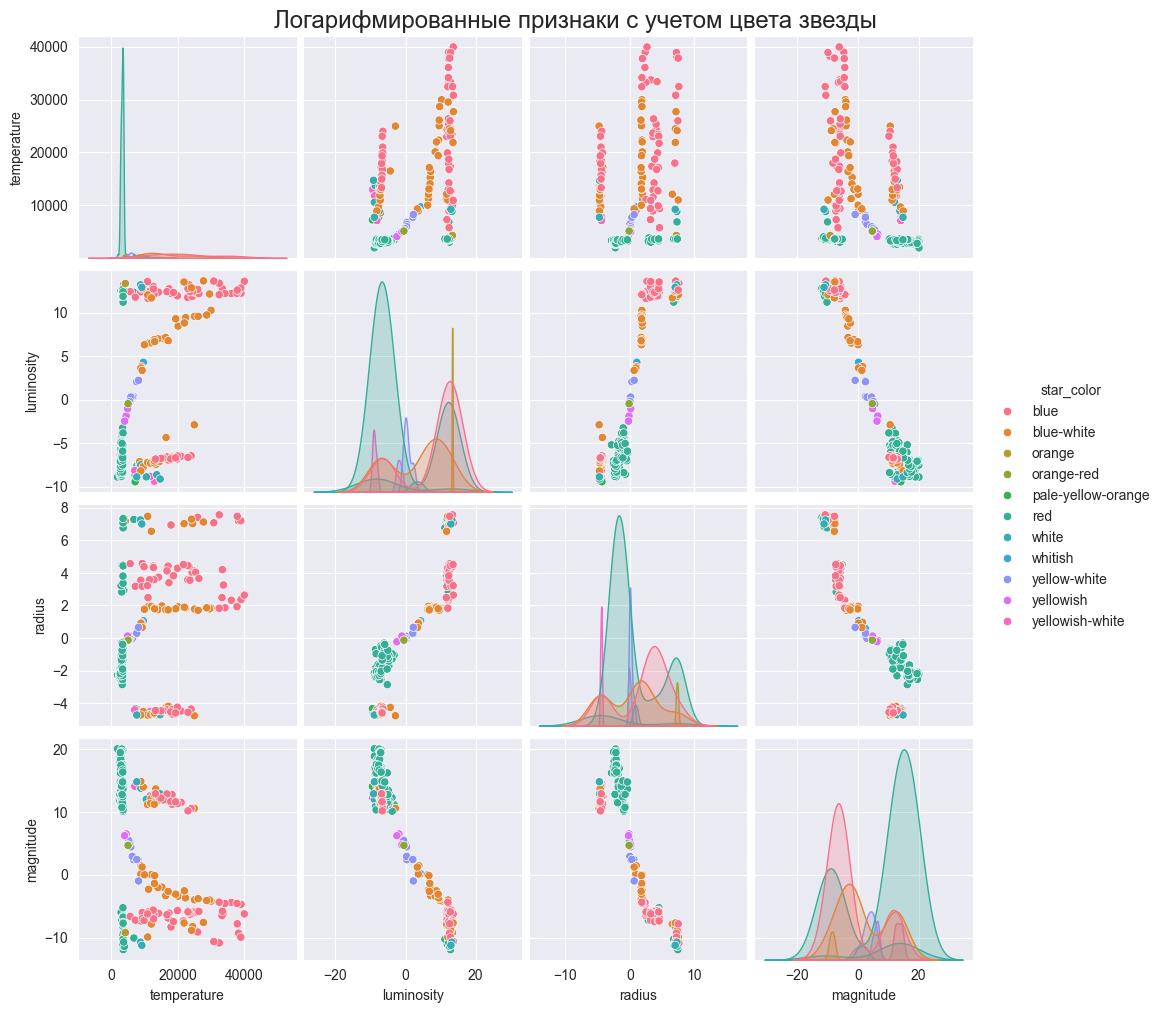

In [16]:
sns.pairplot(data, hue='star_color')
plt.suptitle('Логарифмированные признаки с учетом цвета звезды', y=1.01, fontsize='xx-large');

__Комментарий__  
- Заметно, что кластеры голубых, бело-голубых звезд и красных, белых звезд по разному группируются на графике  
- У звезд, в цвете которых присутствует желтый цвет, чаще наблюдается линейная связь.

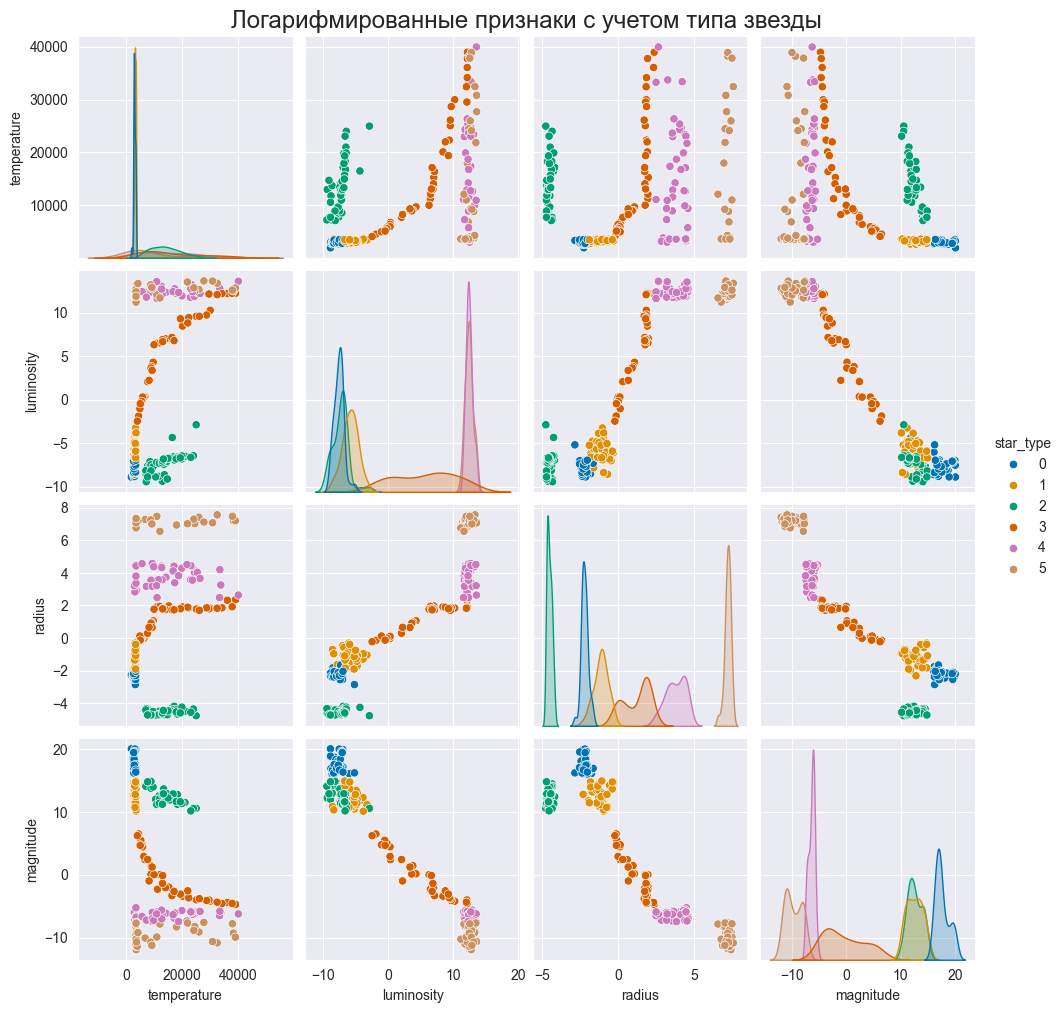

In [17]:
sns.pairplot(data, hue='star_type')
plt.suptitle('Логарифмированные признаки с учетом типа звезды', y=1.01, fontsize='xx-large');

__Комментарий__  
- Заметно четкое деление на кластеры
- У третьей группы явная линейная взаимосвязь

### Вывод    
- Признаки, кроме magnitude, зажаты влево 
- Типы звезд распределены равномерно 
- Большое преобладание красных звезд (половина из датасета)
- Корреляция присутствует практически между всеми признаками (в среднем 0.6-0.7) кроме radius 
- Прослеживается наличие нескольких видов связей между признаками
- На логарифмированных данных более четко прослеживаются связи и кластеры типов/цвета звезд


# Подготовка к моделированию

In [18]:
# Разделение на признаки и цель
target = data['temperature']
features = data.drop('temperature', axis=1)

# Выделение числовых и категориальных переменных
num_cols = features.select_dtypes(include='float64').columns.tolist()
cat_cols = features.select_dtypes(exclude='float64').columns.tolist()

In [19]:
# Масштабирование целевой переменной
target = target.values.reshape(-1,1)
scaler = StandardScaler()
target = scaler.fit_transform(target)
target = target.reshape(240,)
target = pd.Series(target)

In [20]:
# Разделение на тестовую и тренировочную выборки
features_train, features_test, target_train,  target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=RS)
print(f'Величина тренировочного датасета: {features_train.shape[0]}')
print(f'Величина тестового датасета: {features_test.shape[0]}')

Величина тренировочного датасета: 180
Величина тестового датасета: 60


In [21]:
# Масштабирование числовых переменных
transformer = QuantileTransformer(random_state=RS, output_distribution='normal', n_quantiles=60)

features_train[num_cols] = transformer.fit_transform(features_train[num_cols])

features_test[num_cols] = transformer.transform(features_test[num_cols])

In [22]:
# Кодирование категориальных преременных
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

encoder.fit_transform(features_train[cat_cols])
features_train[encoder.get_feature_names_out()] = encoder.transform(features_train[cat_cols]) 
features_train.drop(cat_cols, axis=1, inplace=True)

features_test[encoder.get_feature_names_out()] = encoder.transform(features_test[cat_cols])
features_test.drop(cat_cols,axis=1, inplace=True)

In [23]:
# Функция ошибки
loss = nn.MSELoss(reduction='sum')

# Перевод датасета в тензор
x = torch.FloatTensor(features_train.values)
y = torch.FloatTensor(target_train.values)
x_test = torch.FloatTensor(features_test.values)
y_test = torch.FloatTensor(target_test.values)

### Вывод
- Признаки разделены на тренировочный и тестовый сеты. Тестовый составляет 25% от общего размера.
- Целевой признак масштабирован с использованием StabdardScaler
- Для масштабирования числовых преременных выбран QuantileTransformer с выводом нормального распределения, количеством квантилей - 60.
- Категориальные переменные обработаны OneHotEncoder.
- Определена функция ошибки.
- Данные переведены в тензоры для удобоваримости модели

# Моделирование

### Baseline

In [24]:
# Архитектура сети
class Baseline(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.ac1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.ac2 = nn.Tanh()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

     
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=1, std=1)
        
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=1, std=4)
    
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')

        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.ac1(x)
        
        x = self.fc2(x)
        x = self.ac2(x)
        
        x = self.fc3(x)

        return x
    
# Инициализация сети
baseline = Baseline(18,9,4,1)

In [25]:
# Обучение сети
loss_values_train, loss_values_test, losses, results = training(baseline, num_epochs)
# Вычисление метрики
df = evaluation(losses,results,target_test)

Проведено: 2500 эпох.
Лучшая RMSE: 3871.2291854775963 на 373 эпохе.


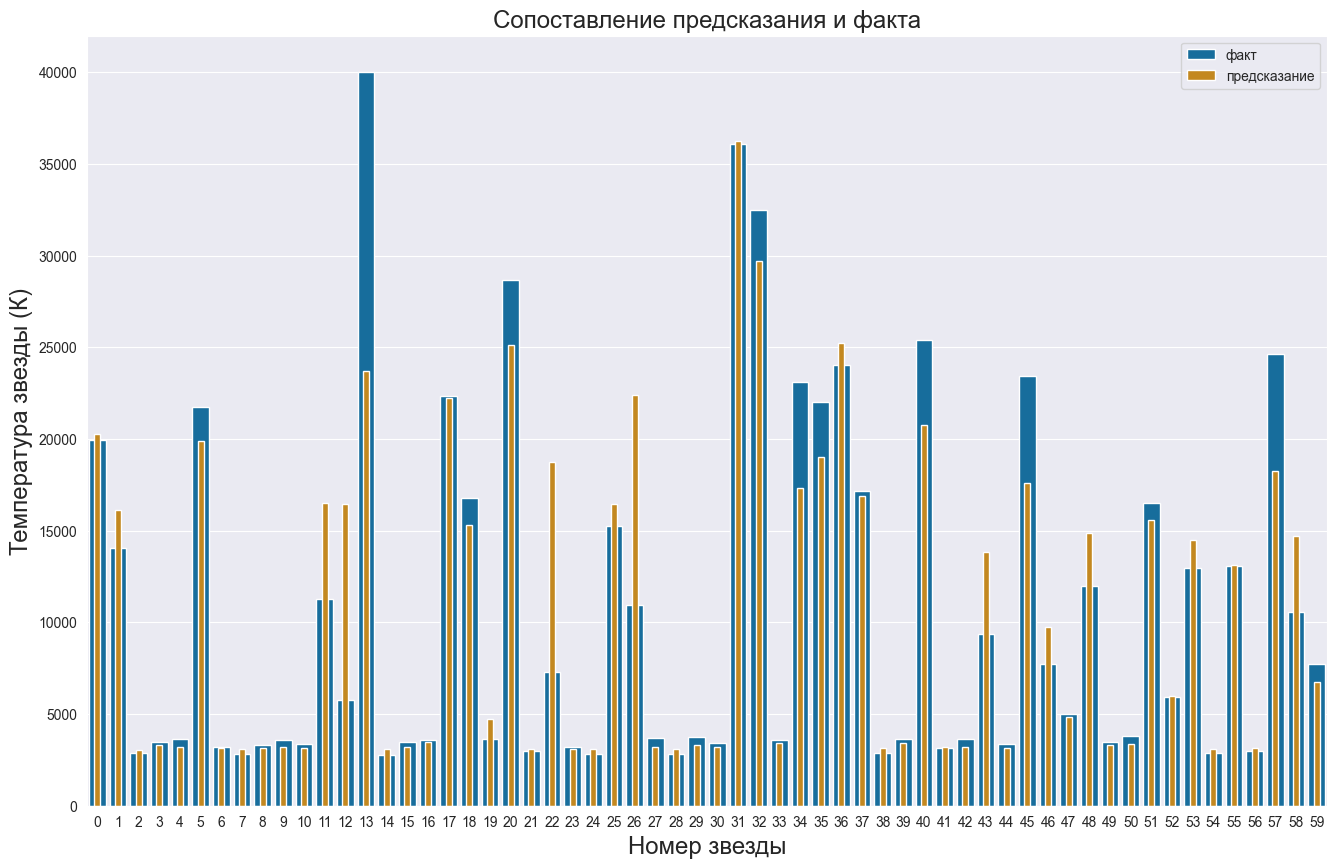

In [26]:
# Визуализация результатов
results_visualization(df)

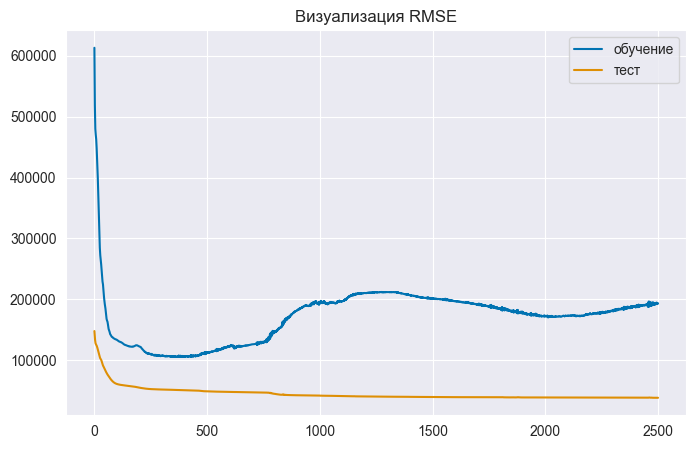

In [27]:
# Визуализация ошибки
RMSE_visualization(loss_values_train, loss_values_test)

__Комментарий__
- Архитектура сети: 
    - 2 скрытых уровня
    - Функции активации: ReLU() на первом, на втором - Tanh(). На последнем - линейная функция.
    - Инициализация весов по методу Кайминга для несимметричных Функций
    - Инициализация сдвигов нормальным распределением со средним 1 и стандартным отклонением 1 в первом слое и 1 и 4 - во втором
    - Дисперсия сохраняется при прямом распроостранении везде, кроме второго слоя.
    - Количество нейронов: 18 - входной слой, 9 - первый скрытый, 4 - второй скрытый, 1 - на выходном слое. 
- Результаты:   
    - Проведено 2500 эпох обучения.
    - Лучшее значение  RMSE 3871.23 на 373 эпохе



### BatchNorm

In [28]:
# Архитектура сети
class BatchNorm(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(BatchNorm, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.ac1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.ac2 = nn.Tanh()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

     
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=1, std=1)
        
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=1, std=4)
    
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')

        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.ac1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.ac2(x)
        
        x = self.fc3(x)

        return x
    
# Инициализация сети
batchnorm = BatchNorm(18,9,4,1)

In [29]:
# Обучение сети
loss_values_train, loss_values_test, losses, results = training(batchnorm, num_epochs)
# Вычисление метрики
df = evaluation(losses,results,target_test)

Проведено: 2500 эпох.
Лучшая RMSE: 4667.516827260476 на 62 эпохе.


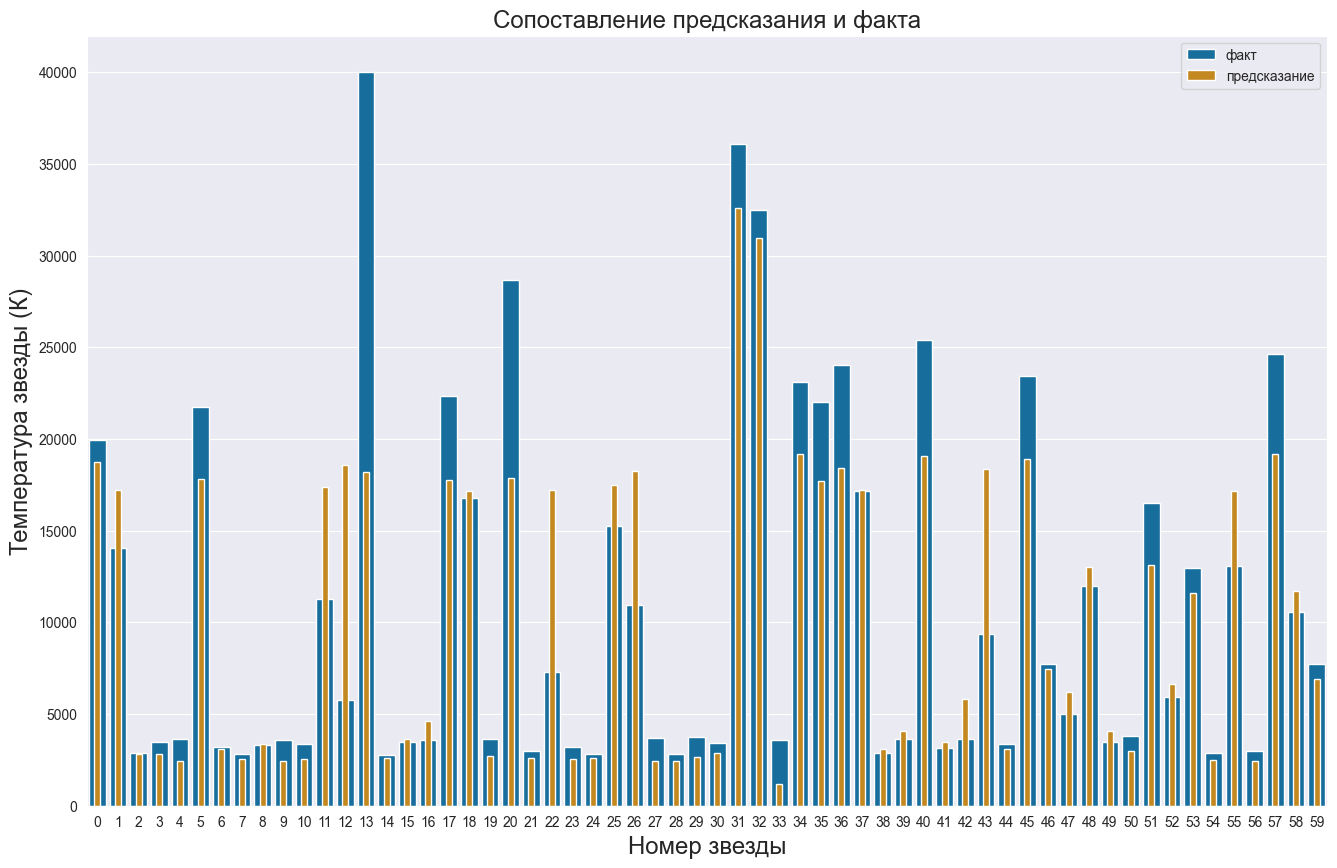

In [30]:
# Визуализация результатов
results_visualization(df)

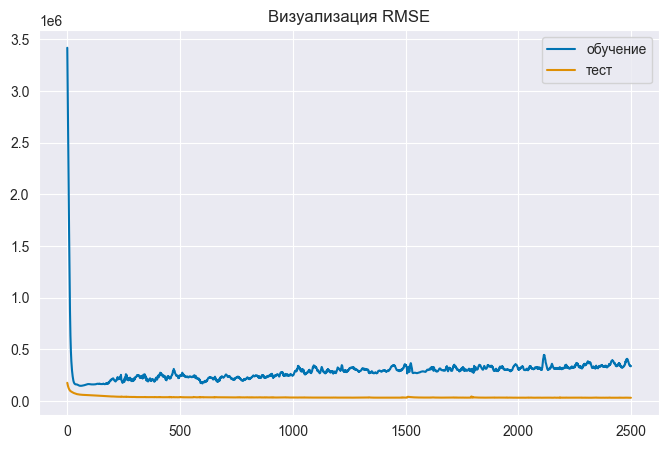

In [31]:
# Визуализация ошибки
RMSE_visualization(loss_values_train, loss_values_test)

__Комментарий__
- Архитектура сети: 
    - аналогична baseline
    - добавлены слои BatchNorm перед функциями активации в два скрытых уровня.
- Результаты:  
    - Проведено 2500 эпох обучения.
    - Лучшая RMSE: 4667.52 на 62 эпохе.
    - Сеть достаточно хорошо предсказывает температуру звезд в пределех 5000К. С более высокими значениями возникают промахи.


### DropOut

In [32]:
rmse_target = 4500
best_p = 0

for p in np.arange(0.05,0.3,0.02):
# Архитектура сети
    class DropOut(nn.Module):
        def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(DropOut, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.ac1 = nn.ReLU()
            self.dp1 = nn.Dropout(p=p)

            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.ac2 = nn.Tanh()
            self.dp2 = nn.Dropout(p=p)

            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)


            nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.normal_(self.fc1.bias, mean=1, std=1)

            nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
            nn.init.normal_(self.fc2.bias, mean=1, std=4)

            nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')


        def forward(self, x):

            x = self.fc1(x)
            x = self.ac1(x)
            x = self.dp1(x)

            x = self.fc2(x)
            x = self.ac2(x)
            x = self.dp2(x)

            x = self.fc3(x)

            return x

    # Инициализация сети
    dropout = DropOut(18,9,4,1)

    # Обучение сети
    loss_values_train, loss_values_test, losses, results = training(dropout, num_epochs)
    
    # Вычисление метрики
    print(f'p={p}')
    df = evaluation(losses,results,target_test)
    print('*' * 8)
    
    # Отбор лучших результатов для визуализации
    rmse = mean_squared_error(df['target'], df['preds'], squared=False)
    if  rmse < rmse_target:
        df_ = df
        loss_values_train_ = loss_values_train
        loss_values_test_ = loss_values_test
        best_p = p
        rmse_target = rmse

p=0.05
Проведено: 2500 эпох.
Лучшая RMSE: 4105.131692407174 на 2317 эпохе.
********
p=0.07
Проведено: 2500 эпох.
Лучшая RMSE: 4372.866385721161 на 808 эпохе.
********
p=0.09000000000000001
Проведено: 2500 эпох.
Лучшая RMSE: 4415.884696652825 на 2464 эпохе.
********
p=0.11000000000000001
Проведено: 2500 эпох.
Лучшая RMSE: 4612.934575026324 на 2181 эпохе.
********
p=0.13
Проведено: 2500 эпох.
Лучшая RMSE: 4501.5451319000085 на 1570 эпохе.
********
p=0.15000000000000002
Проведено: 2500 эпох.
Лучшая RMSE: 4467.6675137527045 на 743 эпохе.
********
p=0.17000000000000004
Проведено: 2500 эпох.
Лучшая RMSE: 4405.912541973088 на 1206 эпохе.
********
p=0.19
Проведено: 2500 эпох.
Лучшая RMSE: 4634.564316635059 на 1353 эпохе.
********
p=0.21000000000000002
Проведено: 2500 эпох.
Лучшая RMSE: 5006.127122740127 на 2144 эпохе.
********
p=0.23000000000000004
Проведено: 2500 эпох.
Лучшая RMSE: 4489.289816864293 на 1355 эпохе.
********
p=0.25000000000000006
Проведено: 2500 эпох.
Лучшая RMSE: 4969.46222300

Лучшее значение RMSE=4105.131692407174 достигается при p=0.05


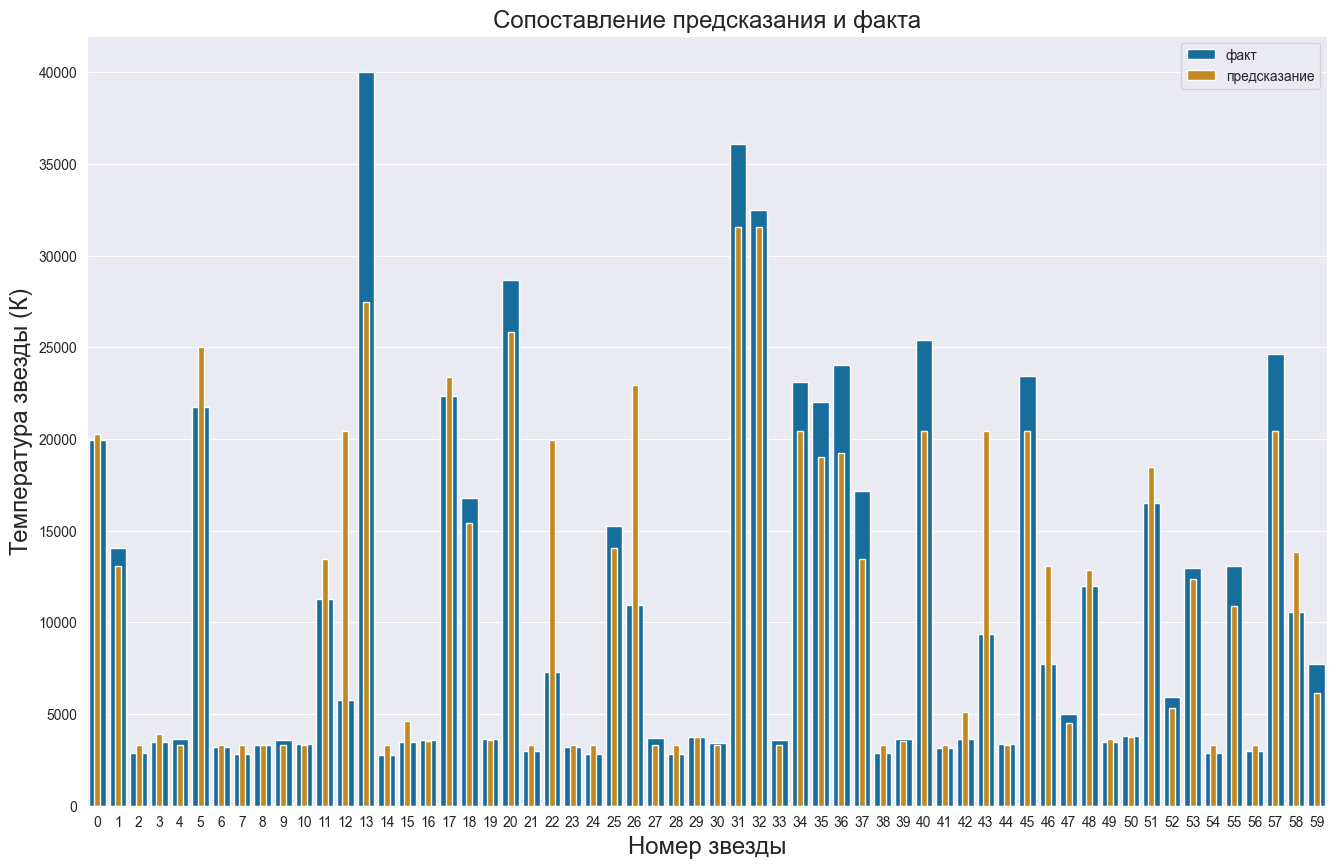

In [33]:
# Визуализация результатов
print(f'Лучшее значение RMSE={rmse_target} достигается при p={best_p}')
results_visualization(df_)

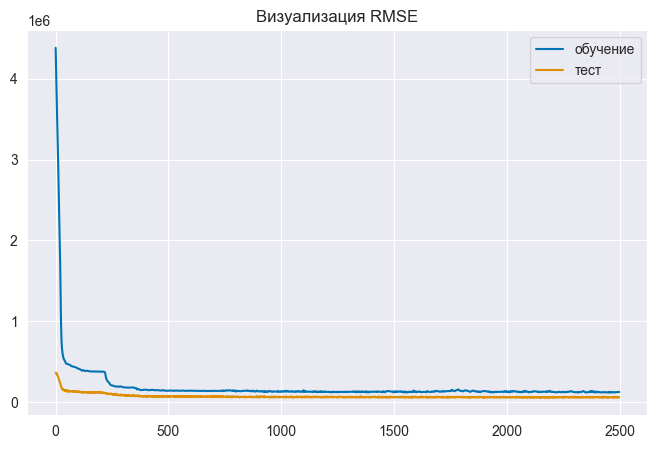

In [34]:
# Визуализация ошибки
RMSE_visualization(loss_values_train_, loss_values_test_)

__Комментарий__
- Архитектура сети: 
    - аналогична baseline
    - добавлены слои Dropout после функций активации в два скрытых уровня.
    - перебраны значения процента выключения нейронов (p) от 0.05 до 0.3 с шагом 0.02.
- Результаты:  
    - проведено 2500 эпох обучения.
    - лучшее значение RMSE = 4105.13 достигается при p = 0.05

### Обучение батчами

In [35]:
# Архитектура сети
class Batches(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Batches, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.ac1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.ac2 = nn.Tanh()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

     
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=1, std=1)
        
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=1, std=4)
    
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')

        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.ac1(x)
        
        x = self.fc2(x)
        x = self.ac2(x)
        
        x = self.fc3(x)

        return x
    
# Инициализация сети
batches = Batches(18,9,4,1)

In [36]:
# Создание списка ошибок
loss_values_train = []
loss_values_test = []

# Создание списка и словаря тестовых результатов и ошибок
results = []
losses = {}

counter = 0
batch_size = 10
num_batches = ceil(len(x)/batch_size)

# Оптимайзер
optimizer = torch.optim.Adam(batches.parameters(), lr=LR)

for epoch in range(num_epochs):
    order = np.random.permutation(len(x))
    for i in range(num_batches):
        start = i * batch_size

        # Обнуление градиента
        optimizer.zero_grad()

        batch_indexes = order[start:start+batch_size]
        x_batch = x[batch_indexes]
        y_batch = y[batch_indexes]

        # Предсказания
        preds = batches.forward(x_batch).flatten()

        # Вычисление ошибки
        loss_value = torch.sqrt(loss(preds, y_batch))

        # Вычисление градиентов функции потерь
        loss_value.backward()

        # Шаг оптимизатора
        optimizer.step()
        
    # Добавление значения ошибки в список ошибок
    loss_value = loss_value.detach().numpy()
    loss_values_train.append(loss_value)

    # Режим предсказания
    batches.eval()

    # Предсказание на тестовых данных
    with torch.no_grad():
        test_preds = batches.forward(x_test).flatten()
        loss_result = loss(test_preds, y_test)

    # Добавление значения ошибки в список ошибок
    loss_result = loss_result.detach().numpy()
    loss_values_test.append(loss_result)

    # Добавление тестовых предсказаний и ошибки в список и словарь
    results.append(test_preds)
    losses[counter] = loss_result
    counter +=1

    # Возврат к тренировочному режиму
    batches.train()

In [37]:
# Вычисление метрики
df = evaluation(losses,results,target_test)

Проведено: 2500 эпох.
Лучшая RMSE: 4447.658669437551 на 1223 эпохе.


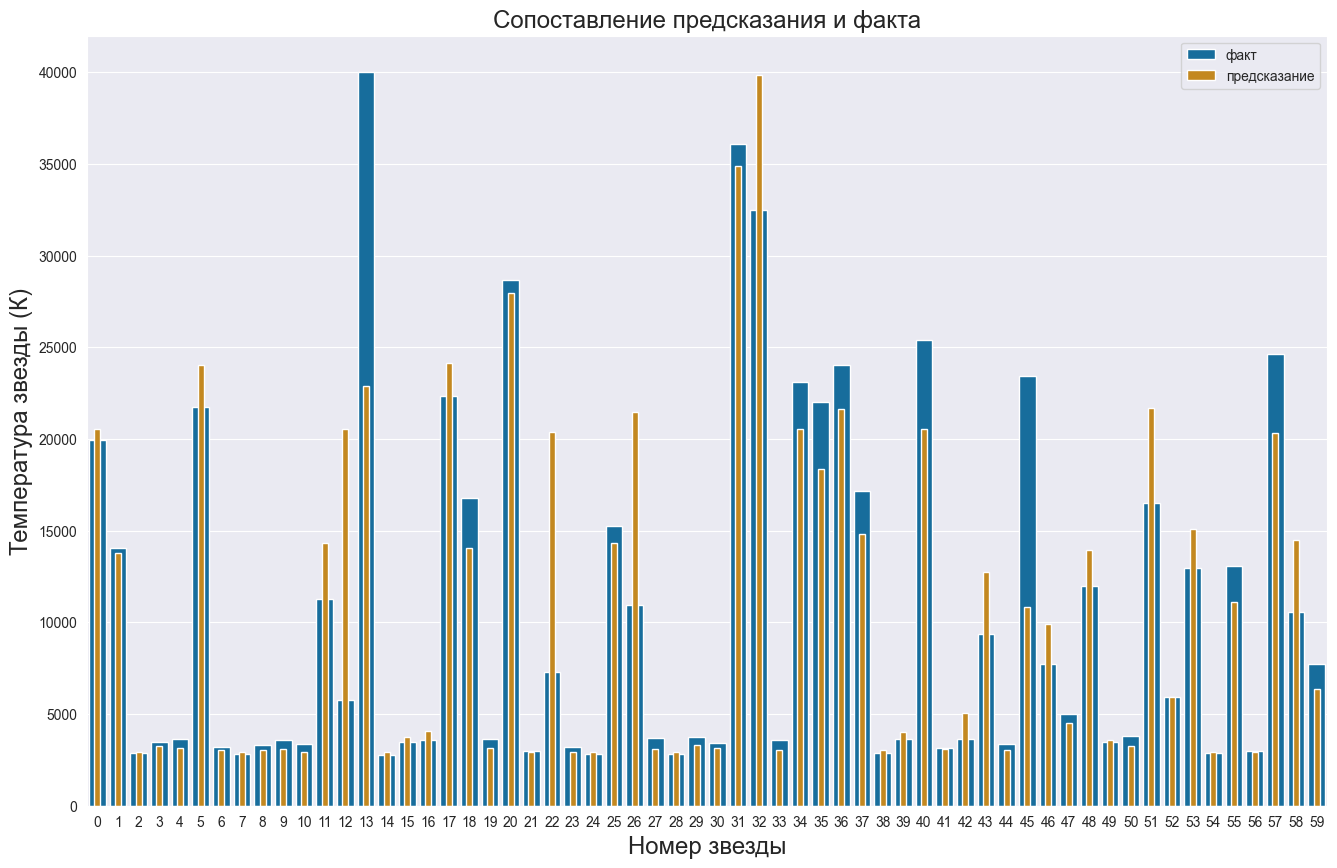

In [38]:
# Визуализация результатов
results_visualization(df)

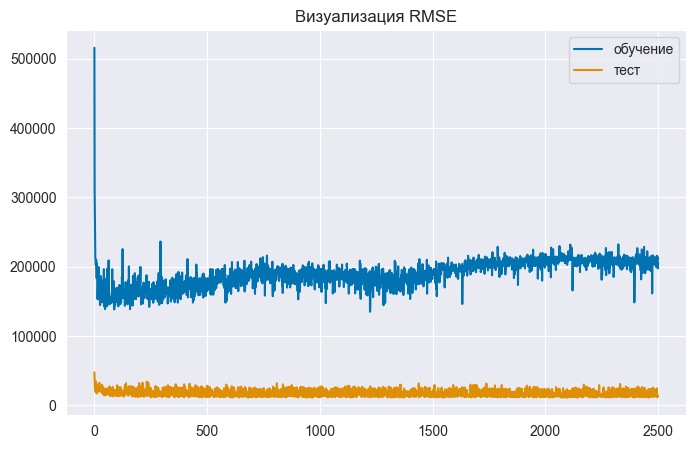

In [39]:
# Визуализация ошибки
RMSE_visualization(loss_values_train, loss_values_test)

__Комментарий__
- Архитектура сети: 
    - аналогична baseline
- Результаты:  
    - Проведено 2500 эпох обучения.
    - Размер батча - 10.
    - Лучшая RMSE: 4447.66 на 1223 эпохе.

### Вывод    
- Построено 4 сети: 
    - baseline
    - с использованием batchnorm
    - с использованием DropOut
    - с обучением по батчам  
- Лучшее значение  RMSE 3871.23 на 373 эпохе у baseline модели


# Общий вывод: 
- Датасет без пропусков и дубликатов
- Исправлены категории в признаке Star_color
- Удалены нерелевантны столбцы
- Проанализированы признаки на графиках 
- Логарифмировано два признака
- Целевой признак трансформирован для обучения и обратно трансформирован для оценки
- Проведено масштабирование числовых и кодирование категориальных признаков
- Обучено 4 сети 
---
Лучшая сеть со значением RMSE 3871.23 - baseline:
- 2 скрытых уровня
- Функции активации: ReLU() на первом, на втором - Tanh(). На последнем - линейная функция.
- Инициализация весов по методу Кайминга для несимметричных Функций
- Инициализация сдвигов нормальным распределением со средним 1 и стандартным отклонением 1 в первом слое и 1 и 4 - во втором
- Дисперсия сохраняется при прямом распроостранении везде, кроме второго слоя.
- Количество нейронов: 18 - входной слой, 9 - первый скрытый, 4 - второй скрытый, 1 - на выходном слое. 